In [1]:
import os
from openai import AzureOpenAI
import base64
import oci
import pandas as pd
import cv2
import matplotlib.pyplot as plt
from PIL import Image
from IPython.display import display, Image
# import re
import shutil
import time
from functools import wraps
import numpy as np
from typing import Any, Callable, TypeVar
import oracledb
from langchain_core.messages import HumanMessage
from langchain_community.vectorstores.utils import DistanceStrategy
from langchain_core.documents import Document
from langchain_community.vectorstores import oraclevs
from langchain_community.vectorstores.oraclevs import OracleVS
from langchain_openai import AzureOpenAIEmbeddings, AzureChatOpenAI
from dotenv import load_dotenv, find_dotenv

_ = load_dotenv(find_dotenv())

OCI_CONFIG_FILE = os.environ["OCI_CONFIG_FILE"]
# Chat AzureOpenAI
AZURE_OPENAI_ENDPOINT=os.environ["AZURE_OPENAI_ENDPOINT"]
AZURE_OPENAI_API_KEY=os.environ["AZURE_OPENAI_API_KEY"]
AZURE_OPENAI_API_VERSION=os.environ["AZURE_OPENAI_API_VERSION"]
AZURE_OPENAI_CHAT_DEPLOYMENT_NAME=os.environ["AZURE_OPENAI_CHAT_DEPLOYMENT_NAME"]

# Other
IMAGE_DIRECTORY_PATH = os.environ["IMAGE_DIRECTORY_PATH"]
OCI_CONFIG_FILE = os.environ["OCI_CONFIG_FILE"]
BUCKET_NAMESPACE = os.environ["BUCKET_NAMESPACE"]
BUCKET_NAME = os.environ["BUCKET_NAME"]
F = TypeVar('F', bound=Callable[..., Any])

In [12]:

config = oci.config.from_file(file_location=OCI_CONFIG_FILE)
namespace = BUCKET_NAMESPACE
bucket_name = BUCKET_NAME
object_storage_client = oci.object_storage.ObjectStorageClient(config)
object_list = object_storage_client.list_objects(BUCKET_NAMESPACE, BUCKET_NAME).data.objects
print(object_list)

[{
  "archival_state": null,
  "etag": null,
  "md5": null,
  "name": "04-7409117_TP_V.jpg",
  "size": null,
  "storage_tier": null,
  "time_created": null,
  "time_modified": null
}, {
  "archival_state": null,
  "etag": null,
  "md5": null,
  "name": "04.Classiclook_Blue_backlight_TP_V.jpg",
  "size": null,
  "storage_tier": null,
  "time_created": null,
  "time_modified": null
}, {
  "archival_state": null,
  "etag": null,
  "md5": null,
  "name": "11898444_2160_3840_60fps.mp4",
  "size": null,
  "storage_tier": null,
  "time_created": null,
  "time_modified": null
}, {
  "archival_state": null,
  "etag": null,
  "md5": null,
  "name": "13193395-uhd_3840_2160_30fps.mp4",
  "size": null,
  "storage_tier": null,
  "time_created": null,
  "time_modified": null
}, {
  "archival_state": null,
  "etag": null,
  "md5": null,
  "name": "16924785-uhd_3840_2160_30fps.mp4",
  "size": null,
  "storage_tier": null,
  "time_created": null,
  "time_modified": null
}, {
  "archival_state": null,
  

In [26]:
for object in object_list:
    # print(object.name)
    if object.name.endswith('.jpg'):
        object_client = object_storage_client.get_object(BUCKET_NAMESPACE, BUCKET_NAME, object.name)
        print(object_client.data.content)
        download_file_path = os.path.join('./tmp_images', os.path.basename(object.name))
        print(f"Downloading {object.name} to {download_file_path}")
        
        with open(download_file_path, "wb") as download_file:
            download_file.write(object_client.data.content)

b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x01\x00H\x00H\x00\x00\xff\xdb\x00C\x00\x08\x06\x06\x07\x06\x05\x08\x07\x07\x07\t\t\x08\n\x0c\x14\r\x0c\x0b\x0b\x0c\x19\x12\x13\x0f\x14\x1d\x1a\x1f\x1e\x1d\x1a\x1c\x1c $.\' ",#\x1c\x1c(7),01444\x1f\'9=82<.342\xff\xdb\x00C\x01\t\t\t\x0c\x0b\x0c\x18\r\r\x182!\x1c!22222222222222222222222222222222222222222222222222\xff\xc0\x00\x11\x08\x04*\x06@\x03\x01"\x00\x02\x11\x01\x03\x11\x01\xff\xc4\x00\x1c\x00\x00\x02\x03\x01\x01\x01\x01\x00\x00\x00\x00\x00\x00\x00\x00\x00\x03\x04\x01\x02\x05\x00\x06\x07\x08\xff\xc4\x00E\x10\x00\x02\x01\x03\x03\x03\x03\x02\x04\x04\x05\x03\x04\x00\x02\x0b\x01\x02\x03\x00\x04\x11\x12!1\x05AQ\x13"a\x06q\x142\x81\x91#B\xa1\xb1\x15Rb\xc1\xd1r\xe1\xf0\x07$3\xf1\x16\x824C%\x92\xa2\xb2S\xc26DT\xff\xc4\x00\x1a\x01\x00\x03\x01\x01\x01\x01\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x01\x02\x03\x04\x05\x06\xff\xc4\x001\x11\x00\x02\x02\x02\x02\x02\x02\x02\x02\x01\x04\x02\x02\x02\x03\x00\x00\x01\x02\x11\x12!\x031"A\x13Q\x04a2qB#\x81\x91\

In [41]:
api_type = "azure"
api_base = AZURE_OPENAI_ENDPOINT
deployment_name = "gpt-4o"
embed_deployment_name = "text-embedding-small"
api_version = "2024-02-15-preview"
api_key = AZURE_OPENAI_API_KEY
directory = './tmp_images'

In [11]:
chat_model = AzureChatOpenAI(
    api_version=AZURE_OPENAI_API_VERSION,
    azure_deployment=AZURE_OPENAI_CHAT_DEPLOYMENT_NAME
)

https://shormv.openai.azure.com/
0f2caf7a0c6d4d539fdcef67ba5888ae
2024-02-15-preview
gpt-4o


In [12]:
def encode_image(image_path: str):
    with open(image_path, "rb") as image_file:
        return base64.b64encode(image_file.read()).decode("utf-8")

In [7]:
directory = './tmp_images'
image_file = '04-7409117_TP_V.jpg'
image_path = f"{directory}/{image_file}"
base64_image = encode_image(image_path)
message = HumanMessage(
    content=[
                {"type": "text", "text": "Describe this image:"},
                {"type": "image_url",
                "image_url": {
                    "url": f"data:image/jpeg;base64,{base64_image}"
                    }
                }
            ]
)
chat_model.invoke([message])

AIMessage(content='The image shows three people enjoying a sunny day outdoors near a body of water. They appear to be playing badminton, with two of them holding rackets. The ground is covered with small white petals or leaves, and the sunlight is reflecting off the water in the background, creating a shimmering effect. The individuals are casually dressed, with one wearing a yellow top and blue jeans, another in darker clothing, and the third person, possibly a child, in a blue top and black pants. The scene conveys a sense of leisure and outdoor activity.', response_metadata={'token_usage': {'completion_tokens': 108, 'prompt_tokens': 950, 'total_tokens': 1058}, 'model_name': 'gpt-4o-2024-05-13', 'system_fingerprint': 'fp_abc28019ad', 'prompt_filter_results': [{'prompt_index': 0, 'content_filter_result': {'jailbreak': {'filtered': False, 'detected': False}, 'custom_blocklists': {'filtered': False, 'details': []}}}, {'prompt_index': 1, 'content_filter_result': {'sexual': {'filtered': F

In [13]:
def image_to_text(directory: str, image_file: str):
    image_path = f"{directory}/{image_file}"
    base64_image = encode_image(image_path)
    message = HumanMessage(
        content=[
            {"type": "text", "text": "Describe this image:"},
                {"type": "image_url",
                "image_url": {
                    "url": f"data:image/jpeg;base64,{base64_image}"
                    }
                }
            ]
    )
    response = chat_model.invoke([message])
    print(response.content)
    return response.content

In [14]:
image_to_text(directory, image_file='04-7409117_TP_V.jpg')

The image shows three people outdoors near a body of water, enjoying a sunny day. Two individuals, one in a yellow jacket and the other in dark clothing, are playing badminton, holding rackets. The ground is covered with white petals, possibly from cherry blossom trees, creating a picturesque scene. The person in the foreground is dressed in dark clothing and appears to be walking or playing on the grassy area. The sunlight reflects off the water in the background, adding a shimmering effect to the scene.


'The image shows three people outdoors near a body of water, enjoying a sunny day. Two individuals, one in a yellow jacket and the other in dark clothing, are playing badminton, holding rackets. The ground is covered with white petals, possibly from cherry blossom trees, creating a picturesque scene. The person in the foreground is dressed in dark clothing and appears to be walking or playing on the grassy area. The sunlight reflects off the water in the background, adding a shimmering effect to the scene.'

In [22]:
embeddings = AzureOpenAIEmbeddings(
    azure_deployment="text-embedding-small",
    api_version=AZURE_OPENAI_API_VERSION,
)
text = "this is a test document"
query_result = embeddings.embed_query(text)
doc_result = embeddings.embed_documents([text, text])
print(query_result)

[-0.0052388994954526424, 0.03880666196346283, 0.03496992960572243, -0.0340912863612175, -0.015434800647199154, -0.03303691744804382, -0.004711714573204517, 0.00976756401360035, -0.010294748470187187, -0.01931546814739704, 0.04425423964858055, -0.01922760345041752, -0.02754540927708149, -0.018524689599871635, 0.04399064928293228, 0.08686834573745728, -0.01777784526348114, 0.002959923353046179, 0.01164932083338499, 0.023591522127389908, 0.02605171874165535, 0.014409719035029411, 0.016298798844218254, 0.00946003943681717, -0.019051874056458473, -0.0639650970697403, -0.03769371658563614, 0.012425454333424568, 0.040358930826187134, -0.07181429117918015, 0.023459726944565773, -0.03866022452712059, -0.009423429146409035, -0.01448293961584568, -0.015420157462358475, 0.01911045052111149, 0.02754540927708149, 0.021160613745450974, -0.0371665321290493, -0.034999217838048935, -0.044722847640514374, -0.04390278458595276, 0.02811652608215809, -0.002218569628894329, 0.016811339184641838, 0.0311917699

In [23]:
def generate_embeddings(text: str):
    return embeddings.embed_query(text)


In [25]:
res = chat_model.invoke([message]) | embeddings
res.invoeke

TypeError: unsupported operand type(s) for |: 'AIMessage' and 'AzureOpenAIEmbeddings'

In [2]:

oracledb.init_oracle_client()

# Oracle Database
UN = os.environ.get("UN")
PW = os.environ.get("PW")
DSN = os.environ.get("DSN")
TABLE_NAME = os.environ["TABLE_NAME"]

embeddings_model = AzureOpenAIEmbeddings(
    azure_deployment="text-embedding-small",
    api_version=AZURE_OPENAI_API_VERSION,
)

Database version: 23.4.0.24.5
[Document(metadata={'image': 'aomidori0I9A9151_TP_V.jpg'}, page_content='The image shows two children sitting side by side in a double stroller. Both children are wearing red tops and dark pants with rolled-up cuffs. They are secured in the stroller with black harnesses. The stroller has a pink padded bar in front of the children and a grey canopy overhead. The children are wearing white shoes and appear to be relaxed, with one child holding a finger to their mouth. The background suggests they are outdoors.'), Document(metadata={'image': 'baby0FTHG7355_TP_V.jpg'}, page_content="The image features a young child sitting in a high chair. The child is wearing a light pink outfit with a white lace collar. The high chair has a tray in front of the child, and the background is bright and softly lit, giving a warm and comfortable atmosphere. The child's hands are resting on the tray."), Document(metadata={'image': 'babyFTHG7521_TP_V.jpg'}, page_content='The image

<module 'matplotlib.pyplot' from '/home/ubuntu/oci_script/o_sample/oci_rag_images_sample_kit/src/.venv/lib/python3.11/site-packages/matplotlib/pyplot.py'>

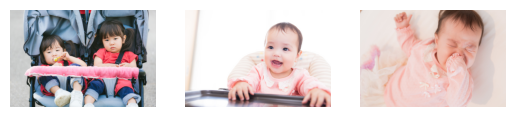

In [4]:
oracledb.init_oracle_client()
query='the man'

with oracledb.connect(user = UN, password = PW, dsn = DSN) as connection:
    print ("Database version:", connection.version)
    vectors = OracleVS(
        client=connection,
        embedding_function=embeddings_model,
        table_name=TABLE_NAME,
        distance_strategy=DistanceStrategy.DOT_PRODUCT,
        )
    response = vectors.similarity_search(query=query, k=3)
print(response)
image_paths = [IMAGE_DIRECTORY_PATH + '/' + image.metadata['image'] for image in response]
print(image_paths)
print(len(image_paths))
for idx, path in enumerate(image_paths):
    img = cv2.imread(path)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.subplot(1, len(image_paths), idx+1)
    plt.imshow(img_rgb)
    plt.axis('off')
plt